# 基础聊天对话

In [1]:
! pip install langgraph langchain_core langchain_openai python-dotenv


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 流程图

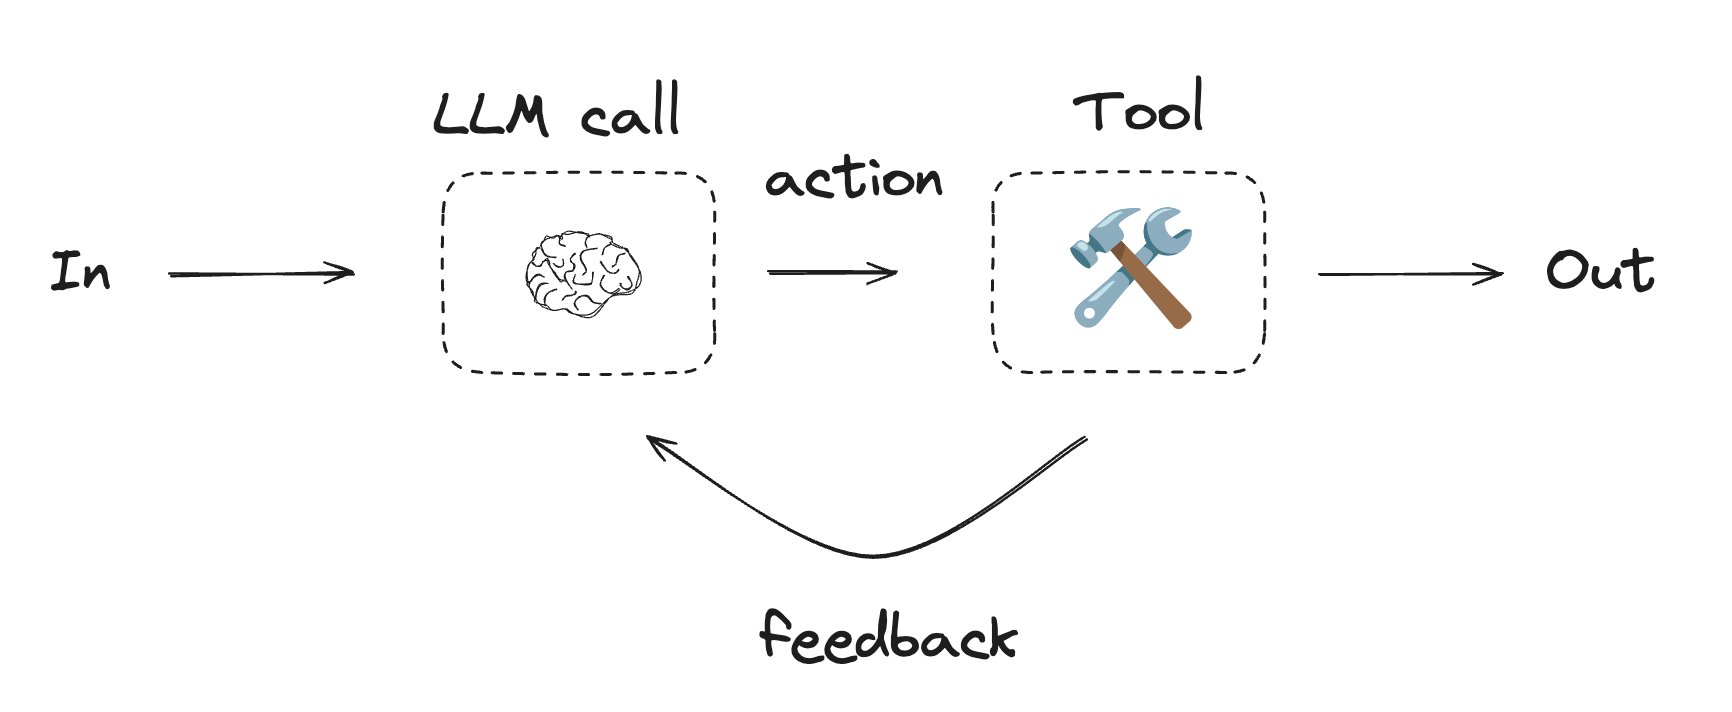

## 定义节点和边

In [2]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.tools import tool
from typing import Literal
from dotenv import load_dotenv
from langgraph.graph import StateGraph, START, END

import os

load_dotenv()

memory = InMemorySaver()


@tool
def getWeather(location: str) -> str:
    """Get the weather for a given location.

    Args:
        location (str): The location to get the weather for.
    """
    return 'Beijing is sunny with a temperature of 25 degrees Celsius.'


llm = ChatOpenAI(
  api_key=os.getenv('OPENAI_API_KEY'),
  base_url=os.getenv('OPENAI_BASE_URL'),
  model=os.getenv('MODEL_NAME')
)

tools = [getWeather]
# 也可以直接生成toolNode，连接到图中
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant."
                    )
                ]
                + state["messages"]
            )
        ]
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END





## 构建图并调用

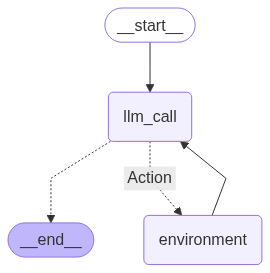

================================ Human Message =================================

今天北京天气咋样.
================================== Ai Message ==================================

我来看看今天北京的天气情况。
Tool Calls:
  getWeather (functions.getWeather:0)
 Call ID: functions.getWeather:0
  Args:
    location: 北京
================================= Tool Message =================================

Beijing is sunny with a temperature of 25 degrees Celsius.
================================== Ai Message ==================================

今天北京是晴天，比较舒适，气温25℃。适合外出活动哦～


In [3]:
from IPython.display import Image, display

agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile(checkpointer=memory)

# Show the agent
display(Image(agent.get_graph().draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="今天北京天气咋样.")]
messages = agent.invoke({"messages": messages}, {"configurable": {"thread_id": 1}})
for m in messages["messages"]:
    m.pretty_print()
